In [1]:
from models.backbone import build_backbone
from models.deformable_transformer import build_deforamble_transformer
from models.deformable_detr import build
from util.misc import NestedTensor

In [27]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
from PIL import Image
import requests
import numpy as np

from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

cuda


In [3]:
# from transformers import AutoImageProcessor, AutoModelForObjectDetection

In [4]:
# class Args:
#     aux_loss = True
#     backbone = 'dino resnet50'
#     dataset = 'owod'
#     dec_layers=6
#     dim_feedforward=1024
#     dilation = False
#     dropout=0.1
#     d_model=256
#     device = 'cuda'
#     dec_n_points = 4
#     enc_layers=6
#     enc_n_points = 4
#     featdim = 1024
#     hidden_dim = 256
#     lr_backbone = 0.01
#     masks = False
#     num_queries = 100
#     num_classes = 81
#     nheads=8
#     num_feature_levels = 4
#     two_stage = False # Experiment with True | False
#     position_embedding = 'learned'  # or 'learned'
#     unmatched_boxes = False
#     with_box_refine = False # Experiment with True | False
#     PREV_INTRODUCED_CLS = 0 # Can also be 19
#     CUR_INTRODUCED_CLS = 80 # Can also be 21
#     NC_branch = False
#     nc_epoch=0
#     set_cost_class=2
#     set_cost_bbox=5
#     set_cost_giou=2
#     cls_loss_coef=2
#     bbox_loss_coef=5
#     giou_loss_coef=2
#     focal_alpha=0.25
#     output_dir=''
#     top_unk=5
#     bbox_thresh=0.3
    
    
# args = Args()

In [29]:
checkpoint = torch.load("../pretrained/checkpoint0044.pth", map_location=device)
print(checkpoint['args'])

Namespace(lr=0.0002, lr_backbone_names=['backbone.0'], lr_backbone=2e-05, lr_linear_proj_names=['reference_points', 'sampling_offsets'], lr_linear_proj_mult=0.1, batch_size=2, weight_decay=0.0001, epochs=45, lr_drop=40, lr_drop_epochs=None, clip_max_norm=0.1, sgd=False, with_box_refine=False, two_stage=False, frozen_weights=None, dilation=False, position_embedding='sine', position_embedding_scale=6.283185307179586, num_feature_levels=4, enc_layers=6, dec_layers=6, dim_feedforward=1024, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, dec_n_points=4, enc_n_points=4, masks=False, aux_loss=True, set_cost_class=2, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, cls_loss_coef=2, bbox_loss_coef=5, giou_loss_coef=2, focal_alpha=0.25, coco_panoptic_path=None, remove_difficult=False, output_dir='exps/OWOD_t1_new_split', device='cuda', seed=42, resume='', start_epoch=0, eval=False, viz=False, eval_every=5, num_workers=2, cache_mode=False, PREV_INTRODUCED_CLS=0, CUR_I

In [30]:
model, criterion, postprocessors = build(checkpoint['args'])
model = model.to(device)

81
DINO resnet50


/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Invalid class rangw: [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


In [31]:
print(checkpoint.keys())
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

dict_keys(['model', 'optimizer', 'lr_scheduler', 'epoch', 'args'])
<All keys matched successfully>


In [32]:
# Load and preprocess the image
def preprocess(image_path):
    transform = T.Compose([
        T.Resize(800),  # Assuming 800 is the input size for the model
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

image_tensor = preprocess("../assets/demo1.jpg")

# Creating a dummy mask (all ones)
mask = torch.ones(image_tensor.size(0), image_tensor.size(2), image_tensor.size(3), dtype=torch.bool)
nested_tensor = NestedTensor(image_tensor, mask).to(device)


In [33]:
%%time
outputs = model(nested_tensor)

CPU times: user 439 ms, sys: 11.6 ms, total: 451 ms
Wall time: 463 ms


In [34]:
outputs

{'pred_logits': tensor([[[-6.1709, -3.6636, -4.2581,  ..., -4.9505, -4.9750, -1.9468],
          [-5.9806, -3.2969, -4.2071,  ..., -4.9241, -4.9475, -1.8376],
          [-6.4084, -3.5499, -4.4630,  ..., -4.9145, -4.9197, -2.1085],
          ...,
          [-6.1738, -3.6669, -4.3914,  ..., -5.0364, -4.8863, -1.9526],
          [-5.9742, -3.5269, -4.2148,  ..., -4.8922, -5.0363, -1.9711],
          [-6.1016, -3.5607, -4.1579,  ..., -4.8638, -4.8572, -2.0381]]],
        device='cuda:0', grad_fn=<SelectBackward0>),
 'pred_nc_logits': tensor([[[-0.9963],
          [-0.8680],
          [-0.9808],
          [-0.9118],
          [-0.8608],
          [-0.7995],
          [-0.6159],
          [-0.8340],
          [-0.8038],
          [-0.7791],
          [-0.5248],
          [-0.5240],
          [-0.5743],
          [-0.8011],
          [-1.0194],
          [-0.8064],
          [-1.0370],
          [-0.8220],
          [-0.7527],
          [-1.0931],
          [-0.7993],
          [-0.6524],
   

In [35]:
outputs.keys()

dict_keys(['pred_logits', 'pred_nc_logits', 'pred_boxes', 'resnet_1024_feat', 'aux_outputs'])

In [36]:
boxes, scores = outputs['pred_boxes'], outputs['pred_logits']

In [37]:
boxes.shape, scores.shape

(torch.Size([1, 100, 4]), torch.Size([1, 100, 81]))

In [38]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)
    return b

In [54]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(device)
    mask = torch.ones(image_tensor.size(0), image_tensor.size(2), image_tensor.size(3), dtype=torch.bool)
    nested_tensor = NestedTensor(image_tensor, mask)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    print(probas)
    keep = probas.max(-1).values > 0.4

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [55]:
im = Image.open("../assets/demo2.jpg")

scores, boxes = detect(im, model, transform)

tensor([[0.0014, 0.0028, 0.0062,  ..., 0.0100, 0.0109, 0.0074],
        [0.0009, 0.0024, 0.0015,  ..., 0.0143, 0.0143, 0.0088],
        [0.0024, 0.0029, 0.0095,  ..., 0.0082, 0.0065, 0.0107],
        ...,
        [0.0026, 0.0018, 0.0066,  ..., 0.0065, 0.0055, 0.0151],
        [0.0048, 0.0041, 0.0055,  ..., 0.0117, 0.0083, 0.0164],
        [0.0020, 0.0010, 0.0070,  ..., 0.0119, 0.0083, 0.0132]],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [56]:
boxes

tensor([[ 829.9540,  515.1769, 1781.9885,  997.5056]], device='cuda:0',
       grad_fn=<MulBackward0>)

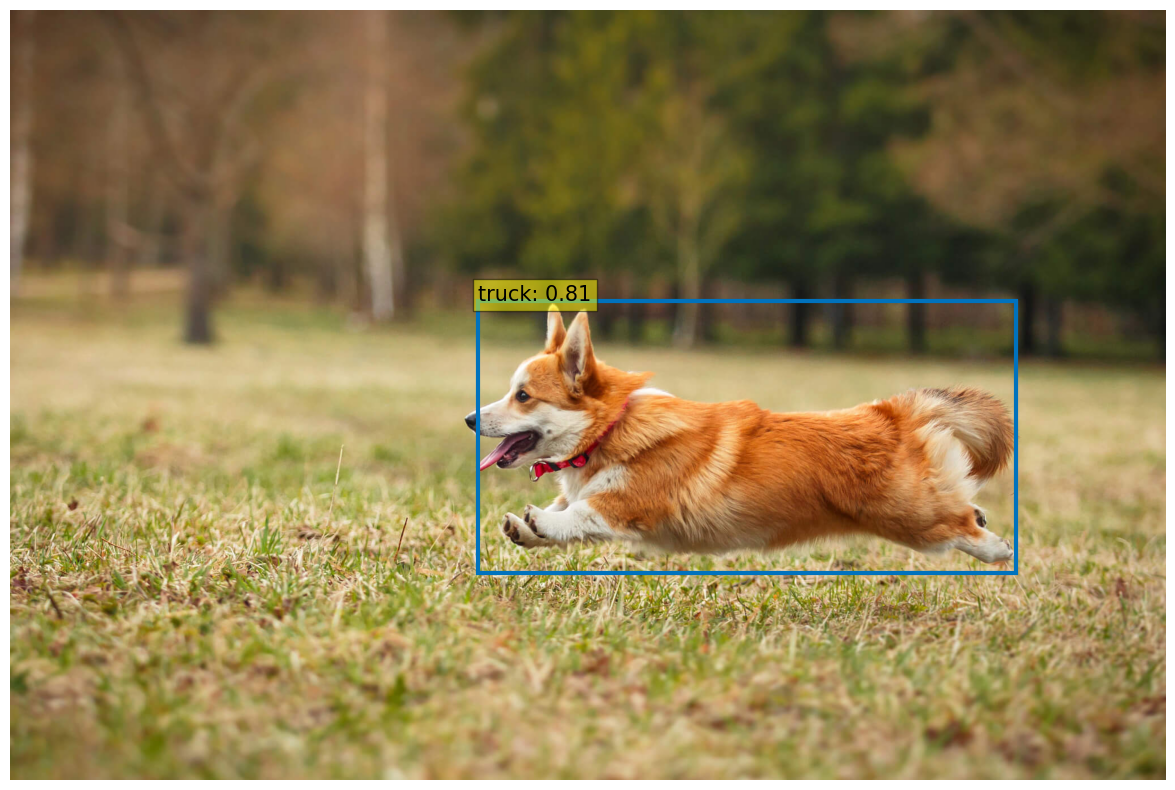

In [57]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(im, scores, boxes)